In [43]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import pandas as pd
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm
import random


In [2]:
groups = ['healthy', 'parkinson']
categories = ['testing','training']
im_types = ['spiral','wave']


cwd = os.getcwd()

base_dir = os.path.join(cwd, 'parkinsons-drawings')

# Walk through the image directory
# Read in images as grayscale and resave
for root, dirs, files in os.walk(base_dir):
    for name in files:
        image = cv2.imread(os.path.join(root, name), 0)
        cv2.imwrite(os.path.join(root,name), image)

In [3]:

# Walk through image directory
# Rescale all spiral drawings to 256x256 and all wave to 256x128 for 
# consistent size to be used as features
for im_type in im_types:
    direc = os.path.join(base_dir, im_type)
    if im_type == 'spiral':
        imsize = (256,256)
    else:
        imsize = (256,128)
    for root, dirs, files in os.walk(direc):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            resized = cv2.resize(image, imsize)
            cv2.imwrite(os.path.join(root,name), resized)
            

In [4]:

def pickleData():
    
    # Create lists of dictionaries for each image type
    spiral_training = []
    direc = os.path.join(base_dir, 'spiral', 'training')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Spiral', 'Label': label, 'Image': image}
            spiral_training.append(tdict)
    
    spiral_testing = []
    direc = os.path.join(base_dir, 'spiral', 'testing')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Spiral', 'Label': label, 'Image': image}
            spiral_testing.append(tdict)  

    wave_training = []
    direc = os.path.join(base_dir, 'wave', 'training')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Wave', 'Label': label, 'Image': image}
            wave_training.append(tdict)   
        
    wave_testing = []
    direc = os.path.join(base_dir, 'wave', 'testing')

    for root, dirs, files in os.walk(direc, followlinks=False):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            label = name[3]
            tdict = {'Desc': 'Wave', 'Label': label, 'Image': image}
            wave_testing.append(tdict)    

    # Pickle datasets
    pickle.dump(spiral_training, open('spiral_training.p','wb'))
    pickle.dump(spiral_testing, open('spiral_testing.p','wb'))
    pickle.dump(wave_training, open('wave_training.p','wb'))
    pickle.dump(wave_testing, open('wave_testing.p','wb'))

    
def unpickleData():
    spiral_training = pickle.load(open('spiral_training.p','rb'))
    spiral_testing = pickle.load(open('spiral_testing.p','rb'))
    wave_training = pickle.load(open('wave_training.p','rb'))
    wave_testing = pickle.load(open('wave_testing.p','rb'))
    return spiral_training, spiral_testing, wave_training, wave_testing

In [5]:
#pickleData()
spiral_training, spiral_testing, wave_training, wave_testing = unpickleData()


In [6]:
def extractXy(mylist):
    X = []
    y = []
    for entry in mylist:
        X.append(entry.get("Image"))
        y.append(entry.get("Label"))
    return np.array(X), np.array(y)

In [47]:
Xspiral, yspiral = extractXy(spiral_training)
yspiral = [1 if (x == 'H' or x == 1) else 0 for x in yspiral]
print(yspiral)
#print(Xspiral[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
# HogTransformer from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9,
                pixels_per_cell=(16,16),
                cells_per_block=(3,3),
                block_norm = 'L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        def local_hog(X):
            return hog(X,
                      orientations = self.orientations,
                      pixels_per_cell = self.pixels_per_cell,
                      cells_per_block = self.cells_per_block,
                      block_norm = self.block_norm,
                      feature_vector=True)
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])
    


In [48]:
    
hogify = HogTransformer(pixels_per_cell=(18,18),
                        cells_per_block=(3,3),
                        orientations=9, 
                        block_norm='L2-Hys')
scalify = StandardScaler()

Xspiral_hog = hogify.fit_transform(Xspiral)
Xspiral_prepared = scalify.fit_transform(Xspiral_hog)

In [49]:
Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

Xspiraltest_hog = hogify.fit_transform(Xspiraltest)
Xspiraltest_prepared = scalify.fit_transform(Xspiraltest_hog)


In [9]:
'''



SVCpipeline = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(8,8),
                        cells_per_block=(1,1),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42))
])

param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(3,3)],
    'hogify__pixels_per_cell': [(18,18)],
    'classify__C': [8e-4, 9e-4, 1e-3, 1.5e-3],
    'classify__kernel': ['rbf','linear']
    }
]


grid_search = GridSearchCV(SVCpipeline,
                          param_grid,
                          cv=3,
                          n_jobs=-1,
                           scoring='recall',
                           verbose=1,
                           return_train_score=True)

grid_res = grid_search.fit(Xspiral, yspiral)

print(grid_res.best_estimator_)
print(grid_res.best_score_)
'''

"\n\n\n\nSVCpipeline = Pipeline([\n    ('hogify', HogTransformer(pixels_per_cell=(8,8),\n                        cells_per_block=(1,1),\n                        orientations=9, \n                        block_norm='L2-Hys')\n    ),\n    ('scalify', StandardScaler()),\n    ('classify', SVC(random_state=42))\n])\n\nparam_grid = [\n    {'hogify__orientations': [9],\n    'hogify__cells_per_block': [(3,3)],\n    'hogify__pixels_per_cell': [(18,18)],\n    'classify__C': [8e-4, 9e-4, 1e-3, 1.5e-3],\n    'classify__kernel': ['rbf','linear']\n    }\n]\n\n\ngrid_search = GridSearchCV(SVCpipeline,\n                          param_grid,\n                          cv=3,\n                          n_jobs=-1,\n                           scoring='recall',\n                           verbose=1,\n                           return_train_score=True)\n\ngrid_res = grid_search.fit(Xspiral, yspiral)\n\nprint(grid_res.best_estimator_)\nprint(grid_res.best_score_)\n"

In [89]:

SVCpipeline = Pipeline([
    ('hogify', HogTransformer()
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42))
])

clf = SVCpipeline.fit(Xspiral, yspiral)

Xspiraltest, yspiraltest = extractXy(spiral_testing)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]
print(yspiraltest)

yspiralpred = clf.predict(Xspiraltest)
print(yspiralpred)


print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))
print('Recall: ', recall_score(yspiraltest, yspiralpred))


confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

(tn, fp, fn, tp) = confusion_spiral.flatten()
print("precision :", tp / float((tp + fp)))
print("f1: ", f1_score(yspiraltest, yspiralpred))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
[False False False False False  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
 False  True False  True  True  True]
Accuracy:  0.7333333333333333
Recall:  0.6666666666666666
precision : 0.7692307692307693
f1:  0.7142857142857142


In [88]:
SVCpipelineOptimized = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(18,18),
                        cells_per_block=(3,3),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42,  C = 0.0008, kernel = 'linear'))
])

op_clf = SVCpipelineOptimized.fit(Xspiral, yspiral)

yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]

yspiralpred = op_clf.predict(Xspiraltest)


print(np.array(yspiralpred == yspiraltest))
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))
print('Recall: ', recall_score(yspiraltest, yspiralpred))

confusion_spiral = confusion_matrix(yspiraltest, yspiralpred)
df = pd.DataFrame(confusion_spiral)
df

(tn, fp, fn, tp) = confusion_spiral.flatten()
print("precision :", tp / float((tp + fp)))
print("f1: ", f1_score(yspiraltest, yspiralpred))

[False False False  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True False  True  True  True  True
  True  True False  True  True  True]
Accuracy:  0.8
Recall:  0.8
precision : 0.8
f1:  0.8000000000000002


In [94]:
from keras import layers
from keras import models
import keras_metrics

model = models.Sequential()
model.add(layers.Conv2D(32,(5,5),activation='relu',
                       input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 252, 252, 32)      832       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               62980352  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [95]:

from keras.utils import to_categorical

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])



Xspiral, yspiral = extractXy(spiral_training)

Xspiraltest, yspiraltest = extractXy(spiral_testing)

Xspiral = Xspiral.reshape(72, 256, 256, 1)
Xspiral = Xspiral.astype('float32') / 255

yspiral = [1 if (x == 'H' or x == 1) else 0 for x in yspiral]



model.fit(Xspiral, yspiral,
         epochs=42,
         verbose=1
         )


Epoch 1/42
72/72 [==============================] - 7s 100ms/step - loss: 9.3639 - accuracy: 0.5000
Epoch 2/42
72/72 [==============================] - 5s 76ms/step - loss: 2.7756 - accuracy: 0.5556
Epoch 3/42
72/72 [==============================] - 5s 73ms/step - loss: 0.6946 - accuracy: 0.4583
Epoch 4/42
72/72 [==============================] - 6s 78ms/step - loss: 0.7221 - accuracy: 0.4583
Epoch 5/42
72/72 [==============================] - 5s 76ms/step - loss: 0.6918 - accuracy: 0.5278
Epoch 6/42
72/72 [==============================] - 6s 78ms/step - loss: 0.6829 - accuracy: 0.6250
Epoch 7/42
72/72 [==============================] - 6s 82ms/step - loss: 0.8089 - accuracy: 0.4444
Epoch 8/42
72/72 [==============================] - 5s 76ms/step - loss: 0.6858 - accuracy: 0.5417
Epoch 9/42
72/72 [==============================] - 5s 75ms/step - loss: 1.1935 - accuracy: 0.5139
Epoch 10/42
72/72 [==============================] - 6s 78ms/step - loss: 0.7089 - accuracy: 0.5972
Epoch 11

In [96]:

Xspiraltest = Xspiraltest.reshape(30, 256, 256, 1)
yspiraltest = [1 if (x == 'H' or x == 1) else 0 for x in yspiraltest]
print(yspiraltest)

test_loss, test_acc = model.evaluate(Xspiraltest, yspiraltest)
print(test_loss)
print(test_acc)

pred = model.predict_classes(Xspiraltest)
print(pred)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
30/30 [==============================] - 1s 22ms/step
91.51362609863281
0.7666666507720947
[[1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [99]:
confusion_spiral = confusion_matrix(yspiraltest, pred)
df = pd.DataFrame(confusion_spiral)
df
print('Accuracy: ', np.sum(yspiralpred == yspiraltest)/len(yspiraltest))
print('Recall: ', recall_score(yspiraltest, yspiralpred))
(tn, fp, fn, tp) = confusion_spiral.flatten()
print("precision :", tp / float((tp + fp)))
print("f1: ", f1_score(yspiraltest, yspiralpred))


Accuracy:  0.7333333333333333
Recall:  0.6666666666666666
precision : 0.9
f1:  0.7142857142857142


In [100]:
confusion_spiral = confusion_matrix(yspiraltest, pred)
df = pd.DataFrame(confusion_spiral)
df

,0,1
0,14,1
1,6,9


{'training accuracy': 0.5, 'test accuracy': 0.43333333333333335, 'precision': 0.4375, 'recall': 0.4666666666666667, 'f1': 0.45161290322580644}


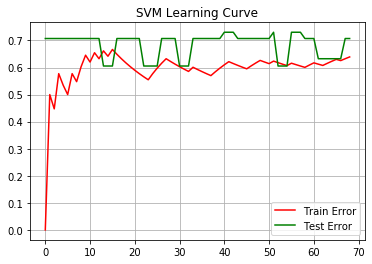

In [91]:
SVCProcessing = Pipeline([
    ('hogify', HogTransformer(pixels_per_cell=(18,18),
                        cells_per_block=(3,3),
                        orientations=9, 
                        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
])


SVCX = SVCProcessing.fit_transform(Xspiral)

SVCmodel = SVC(random_state=42,  C = 0.0008, kernel = 'linear')
SVCmodel.fit(SVCX, yspiral)
random.seed(42)
predSVC = SVCmodel.predict(Xspiraltest_prepared)
metricsSVC = getMetrics(Xspiral_prepared, yspiral, Xspiraltest_prepared, yspiraltest, SVCmodel)
print(metricsSVC)


getLearningCurve(SVCmodel, 'SVM Learning Curve', Xspiraltest_prepared, yspiraltest, Xspiral_prepared , yspiral  )


100 estimators
-----


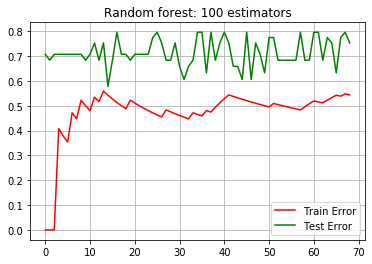


500 estimators
-----


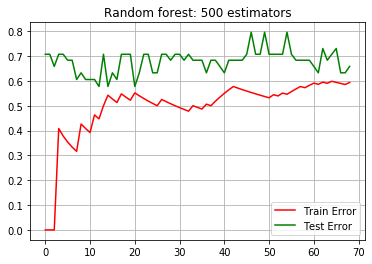


1000 estimators
-----


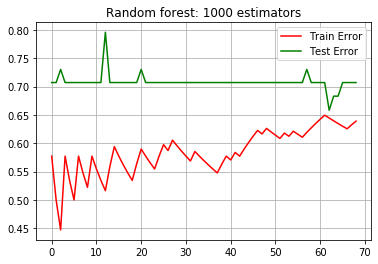

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


ForestProcessing = Pipeline([
    ('hog', HogTransformer(pixels_per_cell=(18,18),
                            cells_per_block=(3,3),
                            orientations=9,
                            block_norm='L2-Hys')
    ),
    ('scale', StandardScaler())
])
def trainForest(newX, n_estimators):
    model = RandomForestClassifier(n_estimators = n_estimators)
    model.fit(newX, yspiral)
    return model 



estimators = [100, 500, 1000]
#hogged = hogify.fit_transform(Xspiraltest)
newX = ForestProcessing.fit_transform(Xspiral)

for n in estimators:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(newX, yspiral)
    pred = model.predict(Xspiraltest_prepared)
    metrics = getMetrics(Xspiral_prepared, yspiral, Xspiraltest_prepared, yspiraltest, model)
    print("\n{x} estimators\n-----".format(x=n))
    getLearningCurve(model, "Random forest: {x} estimators".format(x=n),Xspiraltest_prepared, yspiraltest, Xspiral_prepared, yspiral)
    plt.show()   


In [74]:
def getMetrics(xtrain, ytrain, xtest, ytest, model):
    metrics = {}
    train_pred = model.predict(xtrain)
    cm1 = confusion_matrix(ytrain, train_pred).flatten()
    (tn, fp, fn, tp) = cm1

    metrics["training accuracy"] = (tp + tn) / float(cm1.sum())

    pred = model.predict(xtest)
    cm = confusion_matrix(ytest, pred).flatten()
    (tn, fp, fn, tp) = cm
    

    metrics["test accuracy"] = (tp + tn) / float(cm.sum())
    metrics["precision"] = tp / float((tp + fp))
    metrics["recall"] = tp / float((tp + fn))
    metrics["f1"] = f1_score(ytest, pred)

    return metrics

def getLearningCurve(model, title, xtest, ytest, xtrain, ytrain):
    plt.grid()
    plt.title(title)

    random.seed(42)
    random.shuffle(xtrain)
    random.seed(42)
    random.shuffle(ytrain)
    
    train_err, test_err = [], []
    for m in range(3, len(xtrain)):
        model.fit(xtrain[:m], ytrain[:m])
        ypred = model.predict(xtrain[:m])
        y_test = model.predict(xtest)
        test_err.append(mean_squared_error(ytest, y_test))
        train_err.append(mean_squared_error(ytrain[:m], ypred))

    plt.plot(np.sqrt(train_err), color = 'red', label = 'Train Error')
    plt.plot(np.sqrt(test_err), color = 'green', label = 'Test Error')
    plt.legend()